# 도구 호출 에이전트(Tool Calling Agent)

- 가장 기본적인 형태의 생성형 AI 에이전트(Agent)는 주어진 목표를 달성하기 위해 주변 환경을 관찰하고, 도구를 활용하여 행동하는 애플리케이션
- 에이전트(Agent)는 자율적으로 작동하며, 인간의 개입 없이도 목표를 향해 나아갈 수 있음
- 특히 인간의 명시적인 지시 없이도 스스로 판단하고 행동할 수 있다는 점이 강력한 특징

![alt text](images/1_6_Agent_1.png)

- 도구 호출을 사용하면 모델이 하나 이상의 **도구(tool)** 가 **호출되어야 하는 시기를 감지하고 해당 도구에 전달해야 하는 입력** 으로 전달
- 도구 API 의 목표는 일반 텍스트 완성이나 채팅 API를 사용하여 수행할 수 있는 것보다 더 안정적으로 유효하고 유용한 **도구 호출(tool call)** 을 반환
- 이러한 구조화된 출력을 도구 호출 채팅 모델에 여러 도구를 바인딩하고 모델이 호출할 도구를 선택할 수 있다는 사실과 결합하여 쿼리가 해결될 때까지 반복적으로 도구를 호출하고 결과를 수신하는 에이전트를 만들 수 있음

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [3]:
from langchain.tools import tool
from typing import List, Dict, Annotated
from langchain_teddynote.tools import GoogleNews
from langchain_experimental.utilities import PythonREPL


# 구글 뉴스 도구 생성
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword"""  # 이 내용이 Tool을 선택할 기준이 되므로 잘 작성 되어야 함
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


# 파이썬 실행 도구 생성
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    result = ""
    try:
        result = PythonREPL().run(code)
    except BaseException as e:
        print(f"Failed to execute. Error: {repr(e)}")
    finally:
        return result


print(f"도구 이름: {search_news.name}")
print(f"도구 설명: {search_news.description}")
print(f"도구 이름: {python_repl_tool.name}")
print(f"도구 설명: {python_repl_tool.description}")

도구 이름: search_news
도구 설명: Search Google News by input keyword
도구 이름: python_repl_tool
도구 설명: Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.


In [4]:
# tools 정의
tools = [search_news, python_repl_tool]

## Agent 프롬프트 생성

- `chat_history` : 이전 대화 내용을 저장하는 변수 (멀티턴을 지원하지 않는다면, 생략 가능합니다.)
- `agent_scratchpad` : 에이전트가 임시로 저장하는 변수
- `input` : 사용자의 입력

In [5]:
from langchain_core.prompts import ChatPromptTemplate

# 프롬프트 생성
# 프롬프트는 에이전트에게 모델이 수행할 작업을 설명하는 텍스트를 제공 (도구의 이름과 역할을 입력)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. "
            "Make sure to use the `search_news` tool for searching keyword related news.",
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

## Agent 생성

In [6]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent


# LLM 정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Agent 생성
# chain을 생성하는 단계라고 생각하면 좋음
agent = create_tool_calling_agent(llm, tools, prompt)

In [7]:
agent

RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: message_formatter(x['intermediate_steps']))
})
| ChatPromptTemplate(input_variables=['input'], optional_variables=['agent_scratchpad', 'chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMes

## AgentExecutor

AgentExecutor는 도구를 사용하는 에이전트를 실행하는 클래스입니다.

**주요 속성**
- `agent`: 실행 루프의 각 단계에서 계획을 생성하고 행동을 결정하는 에이전트
- `tools`: 에이전트가 사용할 수 있는 유효한 도구 목록
- `max_iterations`: 실행 루프를 종료하기 전 최대 단계 수
- `max_execution_time`: 실행 루프에 소요될 수 있는 최대 시간
- `handle_parsing_errors`: 에이전트의 출력 파서에서 발생한 오류 처리 방법. (True, False, 또는 오류 처리 함수)

**주요 메서드**
1. `invoke`: 에이전트 실행
2. `stream`: 최종 출력에 도달하는 데 필요한 단계를 스트리밍


In [9]:
from langchain.agents import AgentExecutor

# AgentExecutor 생성
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    max_iterations=10,  # 단계수
    max_execution_time=10,  # 시간
    handle_parsing_errors=True,
)

# AgentExecutor 실행
result = agent_executor.invoke(
    {"input": "한강 작가와 관련된 최신 뉴스 찾아서 불릿으로 정리해줘"}
)

print("Agent 실행 결과:")
print(result["output"])



> Entering new AgentExecutor chain...

Invoking: `search_news` with `{'query': '한강 작가'}`


[{'url': 'https://news.google.com/rss/articles/CBMie0FVX3lxTE4yUWlwRDNNOE0zZ29YdHYyU2JqMGVFTnRyMGI0Nmd2ZWlmclExUHJkQzV2SWMxa2Y3dUdqTklfcE8zU2ZCa09UMzRMbEhVRm1DNGFaeDF2a0FscnY1YWV1dXJmbk5TZGZZTDdJeC1oQU9KeHloTU9BWENiVdIBf0FVX3lxTE9MNWxVQnNjS0R2anlXTktYX1E0Szllc2NPOGtrMGc2UjM5OWltVHVKUWVTNGY3REI5X3htUVBzRWFBak9ybUpDXy1OY0tTR3JuOVZKNkVPODlLQUNaTlZ6ZXE5eDE2d0JSVlprZ0cwTEl0aVUwYlhhRFRFcGFLMFU?oc=5', 'content': 'GGN글로벌광주방송, 한강 작가의‘소년이 온다’속 역사적 진실 조명 - 데일리스포츠한국'}, {'url': 'https://news.google.com/rss/articles/CBMiZEFVX3lxTE1ENmJudlhvX2g4enF4ekN3clM5Sm54bDU3V1UwWE9uRmFRSTBCT0o1TXVJSE9KRUt6YnZtOUdObHFxWTNudnN4bExMSG42eVZua2VUb0dxWGpWdTlRTmJfdWhqcFE?oc=5', 'content': '남양주시, 한강 작가 특별전…남양주시청 및 평내호평역 스마트도서관 전시 "문학적 감동 선사" - 매일일보'}, {'url': 'https://news.google.com/rss/articles/CBMiT0FVX3lxTFBKZHNIdnlwOE9kclVpclhpalctZW1jeXlQZHVNMkZKMThheEpIakl6NFZrNC01aGdVd193SmFWalYwOW9vVWxUb2pvaUxVS2c?oc=5', 'content': "예

In [10]:
from langchain_teddynote.messages import AgentStreamParser

agent_stream_parser = AgentStreamParser()



> Entering new None chain...


Python REPL can execute arbitrary code. Use with caution.


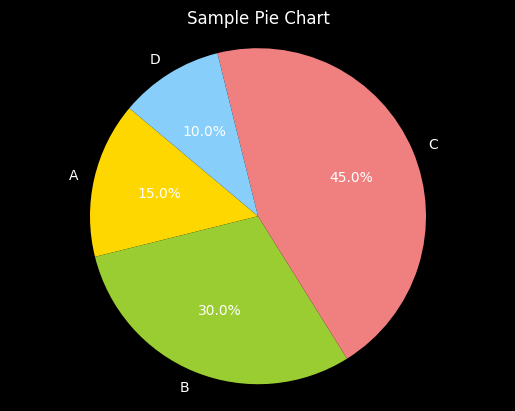

[도구 호출]
Tool: python_repl_tool
code: import matplotlib.pyplot as plt

# 데이터
sizes = [15, 30, 45, 10]
labels = ['A', 'B', 'C', 'D']
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

# 파이 차트 그리기
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sample Pie Chart')

# 차트 보여주기
plt.show()
Log: 
Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as plt\n\n# 데이터\nsizes = [15, 30, 45, 10]\nlabels = ['A', 'B', 'C', 'D']\ncolors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']\n\n# 파이 차트 그리기\nplt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)\nplt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.\nplt.title('Sample Pie Chart')\n\n# 차트 보여주기\nplt.show()"}`




Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as plt\n\n# 데이터\nsizes = [15, 30, 45, 10]\nlabels = ['A', 'B

In [11]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream(
    {"input": "matplotlib 을 사용하여 pie 차트를 그리는 코드를 작성하고 실행하세요."}
)

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    # print(step)
    agent_stream_parser.process_agent_steps(step)



> Entering new None chain...


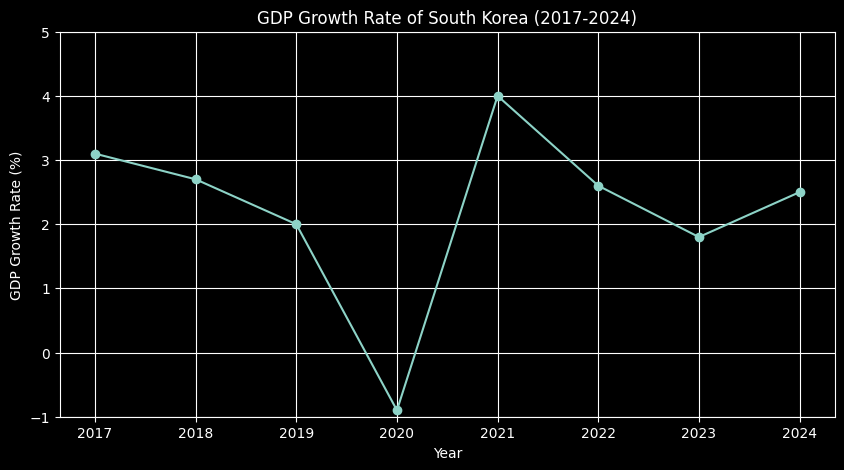

[도구 호출]
Tool: python_repl_tool
code: import matplotlib.pyplot as plt
import numpy as np

# GDP growth rates for South Korea from 2017 to 2024 (estimated)
years = np.array([2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])
gdp_growth_rates = np.array([3.1, 2.7, 2.0, -0.9, 4.0, 2.6, 1.8, 2.5])  # Example values

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(years, gdp_growth_rates, marker='o')
plt.title('GDP Growth Rate of South Korea (2017-2024)')
plt.xlabel('Year')
plt.ylabel('GDP Growth Rate (%)')
plt.xticks(years)
plt.grid(True)
plt.ylim(-1, 5)

# Show the plot
plt.show()
Log: 
Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as plt\nimport numpy as np\n\n# GDP growth rates for South Korea from 2017 to 2024 (estimated)\nyears = np.array([2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])\ngdp_growth_rates = np.array([3.1, 2.7, 2.0, -0.9, 4.0, 2.6, 1.8, 2.5])  # Example values\n\n# Create the plot\nplt.figure(figsize=(10, 5))\nplt.plot(years, gdp_growth_rate

In [14]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream(
    {"input": "대한민국 GDP 성장률 2017년~2024년 찾아서 차트를 그리는 코드를 작성하고 실행하세요. 차트정보는 영어로 작성해주세요"}
)

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    # print(step)
    agent_stream_parser.process_agent_steps(step)

In [ ]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream(
    {"input": "대한민국 작가 한강에 대해서 검색해서 알려주세요."}
)

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    agent_stream_parser.process_agent_steps(step)



> Entering new None chain...
<<<<<<< 도구 호출 >>>>>>
Tool: search_news
<<<<<<< 도구 호출 >>>>>>

Invoking: `search_news` with `{'query': '한강 작가'}`


[{'url': 'https://news.google.com/rss/articles/CBMiaEFVX3lxTFByT1JpVlc1SjlUSFlYYkltRVBTbm9sMko2b05WUy1qRW9hcGR3eFVLdzBfZmFpb0JNOWV0anNUWE1yUFFzZlVuZkxBbjRHd01GM0RtREozVnhPNnl2VWFhX0pCczlocl8w0gFsQVVfeXFMTUFFMkxGUUtTR0hmTHpxWEhsN2lveERMWXktYWVvWlQ2bjJSekttSWtXYUdiTWxlTFR2RThBQnBTX0w0NmU4cU5oc2dENjg2RGtacDZEZkVKWWd6Wmw1MXFKQnhzZU0wUTdEUldx?oc=5', 'content': '남양주시, 6월까지 ‘한강 작가 특별전’ 열어 - 경기도민일보'}, {'url': 'https://news.google.com/rss/articles/CBMiU0FVX3lxTFB6MzlWZ2NMSnN4TGFSeG1hYmhIZ24teUE4TVhQNzc2eTdOajlZSldKLUgxZng2MWprRkYteGlPM2Y2Tm9tZlJCMzRCQUFPSVQxeXhz?oc=5', 'content': "글로벌광주방송, 한강 소설 '소년이 온다' 특집 다큐(종합) - 네이트 뉴스"}, {'url': 'https://news.google.com/rss/articles/CBMiVEFVX3lxTE1nVy1HTmxyUEZLakhGUTRQTDBjSTNqOW5xTlViSjNhLUVabmhLY2FIdHp2ZVBoNllRbHhTQ3FJM1JUem9rajFudGh5Qlhyd0t1MlhMXw?oc=5', 'content': '한강 노벨상 ‘뿌리’ 文鄕 전남 ‘도립문학관’ 건립 속도 - 광주매일신문'}, {'u